## Create the sample data.

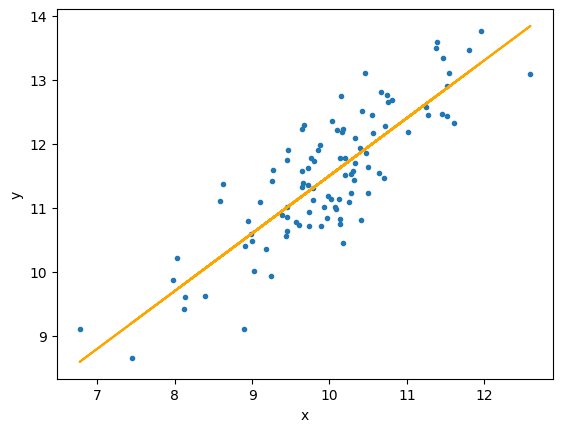

In [1]:
# Create sample data.

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

# Parameters of creating the sample data.

N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

# Model: y = alpha + beta * x + noise
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# Visualize the sample data

plt.plot(x, y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y_real, 'orange')
plt.show()

### Notes
- The goal of this chapter is estimating the linear model (orange line) when the data (blue points) is given. 
- The linear model is defined as "y = alpha * x + beta * x", and the answer is that alpha equals 2,5, and beta equals 0.9, respectively.

## The estimation of the linear regresssion model by MCMC (CANNOT execute in my environment).

In [3]:
import pymc3 as pm

# The definition of model by the PyMC's estimation.

with pm.Model() as model:
    # 1. The definition of the proor possibility distribution.
    
    alpha = pm.Normal('alpha', mu=0, sd=10) # Normalization distrinution (mean=0, standard deviations=10)
    beta = pm.Normal('beta', mu=0, sd=1) # Normalization distrinution (mean=0, standard deviations=1)
    noise = pm.Normal('noise', mu=0, sd=1)
    
    # 2. The likelihood calculation.
    
    y_pred = pm.Normal('y_pred', mu=alpha*x+beta, sd=noise, observed=y)
    
    # 3. Execute the MCMC.
    """
    draws = the number of random numbers, chains = the number of parallel processing.
    """
    trace = pm.sample(draws=5000, chains=1) # Create 5000 randum numbers.
    

/Users/naokimaekawa/Library/Python/3.9/lib/python/site-packages/theano/scalar/basic.py:2412: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  self.ctor = getattr(np, o_type.dtype)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [5]:
trace_n = trace[1000:]
pm.traceplot(trace_n)

pm.summary(trace_n)

NameError: name 'trace' is not defined

## Define the function that doesn't take advantage of pymc3 package.

In [24]:
import numpy as np 

import scipy.stats as stats 

import matplotlib.pyplot as plt 


# Define random.seed

np.random.seed(0) 

# Create ideal data. 

x = np.linspace(0, 10, 1000)
y = 2.5 + 0.5 * x + np.random.normal(scale=1.0, size=1000)

# Metropolis Hastings algorithm.

def metropolis_hastings(lr, iterations, x, y):
    beta_0 = 0
    beta_1 = 0
    sigma = 1
    samples = []
    for i in range(iterations):
        # Define proposal distribution for beta_0, beta_1, sigma, respectively.

        beta_0_proposal = np.random.normal(beta_0, lr)
        beta_1_proposal = np.random.normal(beta_1, lr)
        sigma_proposal = np.random.normal(sigma, lr)

        # Define the likelihood as log of the probability density function.
        
        likelihood_current = np.sum(stats.norm.logpdf(y, beta_0 + beta_1 * x, sigma))
        likelihood_proposal = np.sum(stats.norm.logpdf(y, beta_0_proposal + beta_1_proposal * x, sigma_proposal))

        # Define the prior distribution as log of the probability density function.

        prior_current = stats.norm.logpdf(beta_0, 0, 10) + stats.norm.logpdf(beta_1, 0, 10) + stats.halfnorm.logpdf(sigma, 0, 1)
        prior_proposal = stats.norm.logpdf(beta_0_proposal, 0, 10) + stats.norm.logpdf(beta_1_proposal, 0, 10) + stats.halfnorm.logpdf(sigma_proposal, 0, 1)

        # Acceptance probability
        
        p_accept = np.exp(likelihood_proposal + prior_proposal - likelihood_current - prior_current)

        if np.random.rand() < p_accept:
            beta_0, beta_1, sigma = beta_0_proposal, beta_1_proposal, sigma_proposal


        samples.append([beta_0, beta_1, sigma])

    return np.array(samples)


# Execute the MCMC

samples = metropolis_hastings(0.05, 10000, x, y)

/var/folders/g2/nrr8zz292js1t18sthg2v_yw0000gn/T/ipykernel_64013/1535725965.py:37: RuntimeWarning: overflow encountered in exp
  p_accept = np.exp(likelihood_proposal + prior_proposal - likelihood_current - prior_current)


In [25]:
# Remove born-in period.
burn_in = 500
post_burn_in_samples = samples[burn_in:]

2.4701112130033818 0.4974266544177273


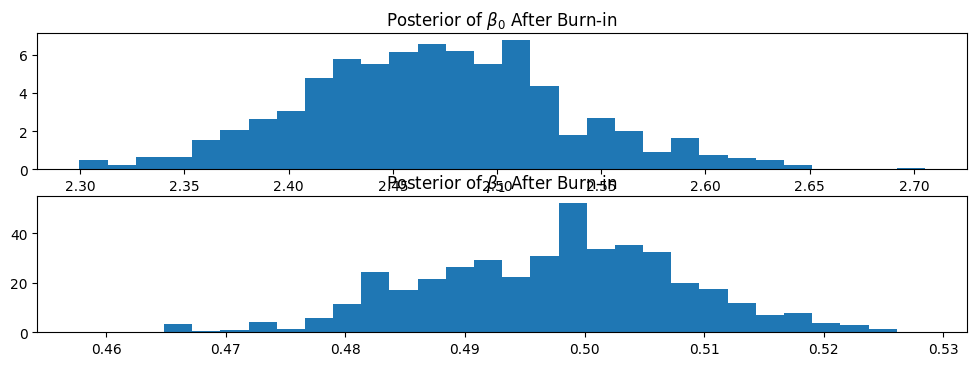

In [26]:
plt.figure(figsize=(12, 6))

# beta_0's posterior distribution
plt.subplot(311)
plt.hist(post_burn_in_samples[:, 0], bins=30, density=True)
plt.title('Posterior of $\\beta_0$ After Burn-in')

# beta_1's posterior distribution
plt.subplot(312)
plt.hist(post_burn_in_samples[:, 1], bins=30, density=True)
plt.title('Posterior of $\\beta_1$ After Burn-in')

# Calculate the means of postrior distribution. 
mean_beta_0 = np.mean(post_burn_in_samples[:, 0])
mean_beta_1 = np.mean(post_burn_in_samples[:, 1])
print(mean_beta_0, mean_beta_1)

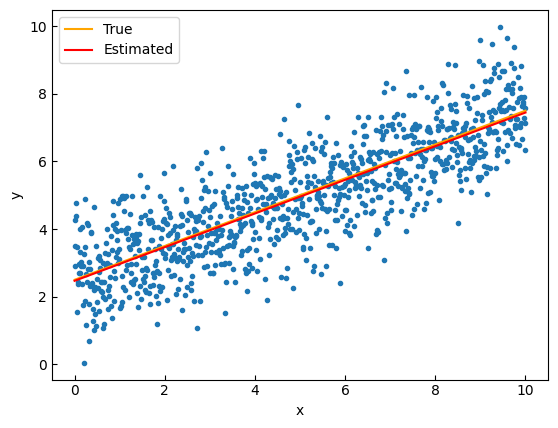

In [27]:
plt.tick_params(direction='in')
plt.plot(x, y, '.')
plt.plot(x, 2.5 + 0.5 * x, 'orange', label='True')
plt.plot(x, mean_beta_0 + mean_beta_1 * x, 'red', label='Estimated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

## References
- https://qiita.com/takubb/items/a2e02fe61aad80f8f2f3 (failed)
- https://blog.since2020.jp/data_analysis/mcmc3/